In [ ]:
The training has been based on the github repo: https://github.com/alexalbu98/Emotion-Detection-From-Tweets-Using-BERT-and-SVM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import unidecode
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score 
import numpy as np
import itertools
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import pickle
import snowballstemmer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
nltk.download("all")

In [2]:
labels = ['joy', 'anger', 'fear', 'sadness', 'neutral']

# Loading the datasets

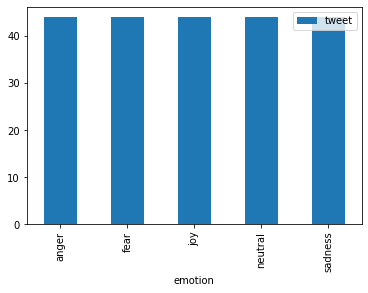

         tweet
emotion       
anger       44
fear        44
joy         44
neutral     44
sadness     44


In [3]:
user_df_train = pd.read_csv("user_train.csv")
user_df_test = pd.read_csv("user_test.csv")
n_samples = user_df_train[["tweet", "emotion"]].groupby("emotion").count()
n_samples.plot(kind="bar")
plt.show()
print(n_samples)

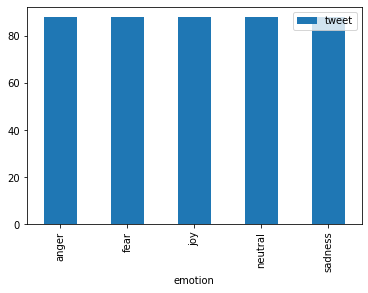

         tweet
emotion       
anger       88
fear        88
joy         88
neutral     88
sadness     88


In [4]:
wassa_and_user_df_train = pd.read_csv("wassa_and_user_train.csv")
wassa_and_user_df_test = pd.read_csv("wassa_and_user_test.csv")
n_samples = wassa_and_user_df_train[["tweet", "emotion"]].groupby("emotion").count()
n_samples.plot(kind="bar")
plt.show()
print(n_samples)

# Useful functions

In [5]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.rcParams.update({'font.size': 20})
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



In [6]:
def preprocess_text(text, stop_words):
    # make lowercase and strip empty spaces
    result = text.lower()
    # strip extra spaces
    result = result.strip()
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", result)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    # strip diacritics
    result = unidecode.unidecode(result)
    # english stopwords
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")

    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += ps.stem(word)
            stemmed_sentence += " "

    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

In [7]:
def preprocess_text_list(text_list, stop_words):
  for i,text in enumerate(text_list):
    text_list[i] = preprocess_text(text_list[i], stop_words)

In [8]:
def pickle_object(object, location):
    filehandler = open(location, "wb")
    pickle.dump(object, filehandler)
    filehandler.close()

def pickle_load_object(location):
    file = open(location, 'rb')
    object = pickle.load(file)
    file.close()
    return object

In [9]:
def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")


# Preprocessing

In [10]:
stop_words = stopwords.words("english")   # loads english stopwords

In [11]:
def preprocessing(df_train, df_test):
    train_texts = df_train["tweet"].tolist()
    test_texts = df_test["tweet"].tolist()
    
    preprocess_text_list(train_texts,stop_words)
    preprocess_text_list(test_texts, stop_words)
    
    train_labels = df_train["emotion"].tolist()
    test_labels = df_test["emotion"].tolist()
    
    return train_texts, test_texts, train_labels, test_labels

In [12]:
train_texts_user, test_texts_user, train_labels_user, test_labels_user = preprocessing(user_df_train, user_df_test)

In [13]:
train_texts_user_wassa, test_texts_user_wassa, train_labels_user_wassa, test_labels_user_wassa = preprocessing(wassa_and_user_df_train, wassa_and_user_df_test)

# Encoding

In [14]:
def text_encoding(train_texts, test_texts):
    # Vectorizing texts
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_texts)
    
    vectorized_train_texts = vectorizer.transform(train_texts)
    vectorized_test_texts = vectorizer.transform(test_texts)
    
    return vectorizer, vectorized_train_texts, vectorized_test_texts

In [15]:
vectorizer_user, vectorized_user_train_texts, vectorized_user_test_texts = text_encoding(train_texts_user, test_texts_user)
vectorizer_user_wassa, vectorized_user_wassa_train_texts, vectorized_user_wassa_test_texts = text_encoding(train_texts_user_wassa, test_texts_user_wassa)

In [16]:
def label_encoding(train_labels, test_labels):
    # label encoding
    label_encoder = LabelEncoder()
    
    encoded_train_labels = label_encoder.fit_transform(train_labels)
    encoded_test_labels = label_encoder.transform(test_labels)
    
    return label_encoder, encoded_train_labels, encoded_test_labels

In [17]:
label_encoder_user, encoded_user_train_labels, encoded_user_test_labels = label_encoding(train_labels_user, test_labels_user)
label_encoder_user_wassa, encoded_user_wassa_train_labels, encoded_user_wassa_test_labels = label_encoding(train_labels_user_wassa, test_labels_user_wassa)

# SVM

## Defining the models

In [21]:
svm_model_user = svm.SVC(probability=True)
svm_model_user.fit(vectorized_user_train_texts, encoded_user_train_labels)

SVC(probability=True)

In [22]:
svm_model_user_wassa = svm.SVC(probability=True)
svm_model_user_wassa.fit(vectorized_user_wassa_train_texts, encoded_user_wassa_train_labels)

SVC(probability=True)

## Testing

### USER ONLY TRAIN AND TEST DATASET

In [23]:
y_pred_user = svm_model_user.predict(vectorized_user_test_texts)

In [24]:
compute_metrics(encoded_user_test_labels, y_pred_user)

Model has acc = 0.6388888888888888
, precision = 0.5901431901431902
, recall = 0.6048229548229548
, f1_score = 0.5930355466130115



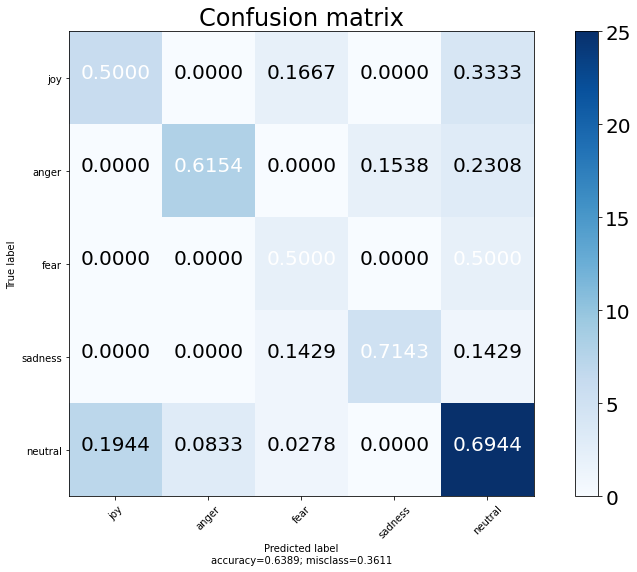

In [26]:
y_pred_user = label_encoder_user.inverse_transform(y_pred_user)
cm = confusion_matrix(test_labels_user, y_pred_user, labels=labels)
plot_confusion_matrix(cm, labels)

In [28]:
print(classification_report(test_labels_user, y_pred_user))

              precision    recall  f1-score   support

       anger       0.73      0.62      0.67        13
        fear       0.33      0.50      0.40         4
         joy       0.46      0.50      0.48        12
     neutral       0.71      0.69      0.70        36
     sadness       0.71      0.71      0.71         7

    accuracy                           0.64        72
   macro avg       0.59      0.60      0.59        72
weighted avg       0.65      0.64      0.64        72



### USER AND WASSA TRAIN AND TEST DATASET

In [29]:
y_pred_user_wassa = svm_model_user_wassa.predict(vectorized_user_wassa_test_texts)

In [30]:
compute_metrics(encoded_user_wassa_test_labels, y_pred_user_wassa)

Model has acc = 0.5069444444444444
, precision = 0.5185074626865671
, recall = 0.4600444193487673
, f1_score = 0.4709817246736751



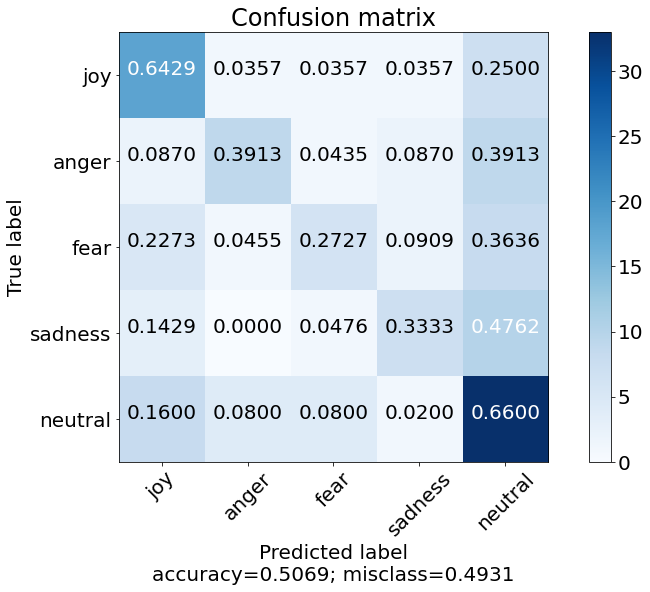

In [31]:
y_pred_user_wassa = label_encoder_user_wassa.inverse_transform(y_pred_user_wassa)
cm = confusion_matrix(test_labels_user_wassa, y_pred_user_wassa, labels=labels)
plot_confusion_matrix(cm, labels)

In [32]:
print(classification_report(test_labels_user_wassa, y_pred_user_wassa))

              precision    recall  f1-score   support

       anger       0.60      0.39      0.47        23
        fear       0.46      0.27      0.34        22
         joy       0.50      0.64      0.56        28
     neutral       0.49      0.66      0.56        50
     sadness       0.54      0.33      0.41        21

    accuracy                           0.51       144
   macro avg       0.52      0.46      0.47       144
weighted avg       0.51      0.51      0.49       144

